In [115]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from datetime import datetime


import shutil
import pandas as pd

In [116]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [117]:
dir_str = "./nus-cs5242/"
shutil.rmtree(dir_str + "train_image/class", ignore_errors=True)
os.mkdir(dir_str + "train_image/class")
os.mkdir(dir_str + "train_image/class/0")
os.mkdir(dir_str + "train_image/class/1")
os.mkdir(dir_str + "train_image/class/2")

label = pd.read_csv(dir_str + "train_label.csv")
label_tupple = list(label.itertuples(index=False, name=None))

for i in range(len(label_tupple)):
    img_ext = str(label_tupple[i][0])
    img_class = str(label_tupple[i][1])
    
    shutil.copy(dir_str + "train_image/train_image/"+img_ext+".png", 
                dir_str + "train_image/class/"+img_class+"/"+img_ext+".png")

data_dir=dir_str + "train_image/class"
data_dir = pathlib.Path(data_dir)
print(data_dir)

nus-cs5242/train_image/class


In [118]:
# create tf datasets and load data, note: didn't use graysacle as all pretrained models over imagenet are RGB 
batch_size = 32
img_height = 512
img_width = 512
num_classes = 3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #labels=train_labels,
  #label_mode='int',
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names


Found 1164 files belonging to 3 classes.
Using 932 files for training.


In [119]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #labels=train_labels,
  #color_mode='grayscale',
  #label_mode='int',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1164 files belonging to 3 classes.
Using 232 files for validation.


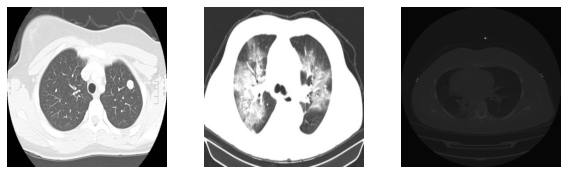

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [121]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(4, 512, 512, 3)
(4,)


In [122]:
#for image_batch, labels_batch in train_ds:
#    print(labels_batch[0])

In [123]:
#for images, labels in train_ds:
#    plt.imshow(images[1])

In [124]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Test transfer learning model ResNet50

In [125]:
# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=(512,512,3),
#                                               include_top=False,
#                                               weights='imagenet')


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

base_model = ResNet50(input_shape=(512,512,3),
                                               include_top=False,
                                               weights='imagenet')


In [126]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [127]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 2048)


In [128]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 172

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  175


In [129]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [130]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [131]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [132]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Normalization(),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [133]:
# construct model 

inputs = tf.keras.Input(shape=(512, 512, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [137]:
base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)


model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [138]:
model.summary()


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 512, 512, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 6147      
Total params: 23,593,866
Trainable params: 10,243
Non-trainable params: 23,583,623
____________________________________

In [139]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
30/30 [==============================] - 19s 633ms/step - loss: 0.5995 - accuracy: 0.7382 - val_loss: 0.4812 - val_accuracy: 0.7802
Epoch 2/30
30/30 [==============================] - 19s 618ms/step - loss: 0.5776 - accuracy: 0.7361 - val_loss: 0.4790 - val_accuracy: 0.7845
Epoch 3/30
30/30 [==============================] - 18s 612ms/step - loss: 0.5786 - accuracy: 0.7436 - val_loss: 0.4785 - val_accuracy: 0.7845
Epoch 4/30
30/30 [==============================] - 18s 610ms/step - loss: 0.5445 - accuracy: 0.7564 - val_loss: 0.4781 - val_accuracy: 0.7802
Epoch 5/30
30/30 [==============================] - 18s 615ms/step - loss: 0.5905 - accuracy: 0.7371 - val_loss: 0.4790 - val_accuracy: 0.7845
Epoch 6/30


KeyboardInterrupt: 

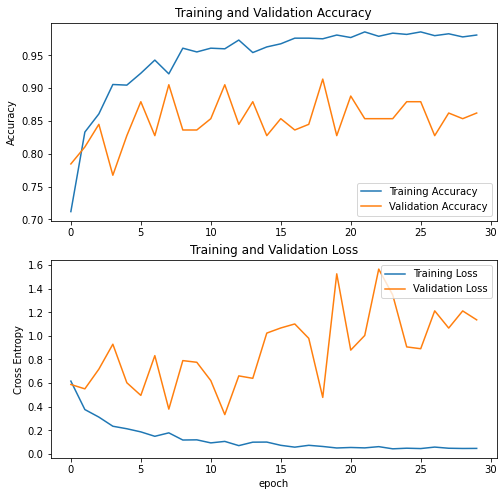

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [86]:
import os

output = []
    
test_folder = dir_str + "test_image/test_image"

for file in os.listdir(test_folder):
    filename = str(file).replace(".png","")
    image_path = os.path.join(test_folder, file)
    #print(filename, image_path)
    
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    label = class_names[np.argmax(score)]
    label = class_names[np.argmax(score)]

    output.append([filename, label])
    #print(
    #    "This image most likely belongs to {} with a {:.2f} percent confidence."
    #    .format(class_names[np.argmax(score)], 100 * np.max(score))
    #)
    

In [87]:
results = pd.DataFrame(output, columns = ['ID' , 'Label']) 
results.ID = results.ID.astype(int)
results = results.sort_values(by="ID")

In [88]:
results.to_csv(dir_str + "submission_resnet50_" + datetime.today().strftime('%Y-%m-%d-%H-%M-%S') + ".csv", index=False)